#### CelebA Attack Notebook

In [1]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import numpy as np
import sys
sys.path.append("..")

from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification import PyTorchClassifier

import yaml
import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from torch import nn
import pytorch_lightning as pl
from dataloader import load_mnist
from typing import Tuple, Callable
from models.classifier import (MNISTClassifier, CIFAR10Classifier,
                                CelebAClassifier)
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CIFAR10Autoencoder, CelebAAutoencoder)

/Users/swainsubrat/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import datetime
import os
import warnings
from pathlib import Path
from typing import Dict

import numpy as np
import torch
import yaml
from torch import nn

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [3]:
class Args:
    batch_size = 32
    attack_name = "deepfool"
    device  = "cuda"
    model_name = "celeba_cnn_1"
    ae_name = "cnn_128"
    plot = False
    plot_dir = "./plots"

args = Args()

In [4]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!") 

Working on the dataset: celeba!!!!!


/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded classifier and autoencoder models in eval mode!!!!!
Loaded dataloader!!!!!


In [5]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
# config["latent_shape"] = args.ae_name.split('_')[-1]
config["latent_shape"] = (16, 16)

In [6]:
# x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
# config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model)

<class 'numpy.ndarray'> (32, 3, 128, 128)
Accuracy on benign test examples: 59.375%
(32, 128, 16, 16)


TypeError: forward() missing 1 required positional argument: 'x2'

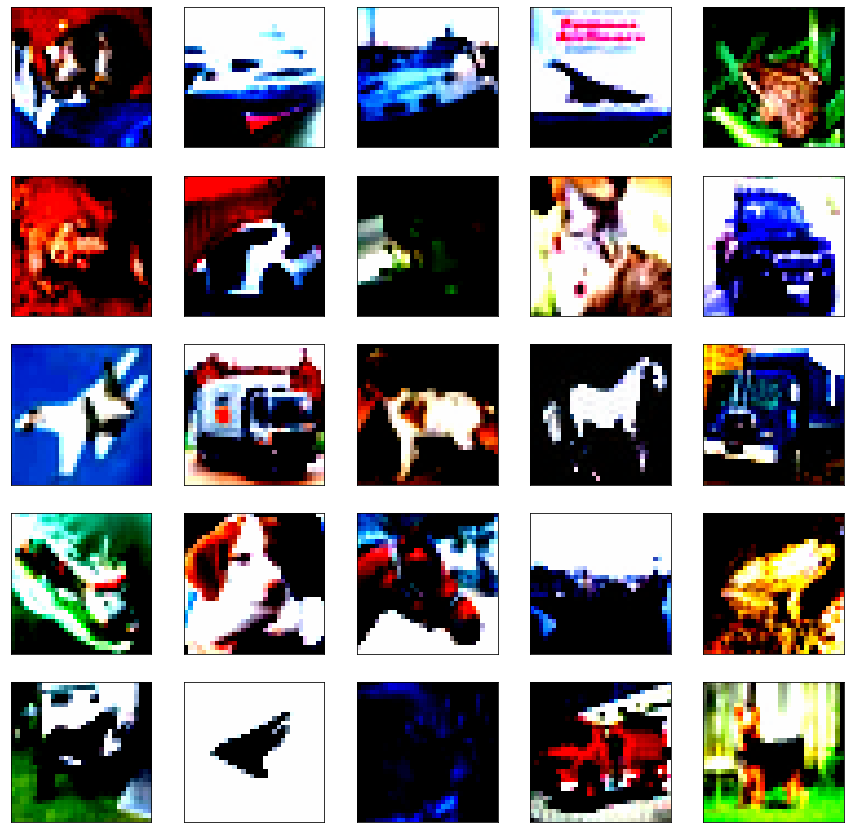

In [22]:
orig_attk_images = result["DeepFool"]["x_test_adv_np"]
modf_attk_images = result["DeepFool"]["xx_test_adv_np"]
hybrid_attk_images = result["DeepFool"]["hybrid_x_np"]

orig_attk_noise = result["DeepFool"]["x_test_noise"]
modf_attk_noise = result["DeepFool"]["xx_test_noise"]
# hybrid_attk_noise = result["DeepFool"]["hybrid_noise"]

plt.figure(figsize=(15, 15))
images = torch.Tensor(orig_attk_images).reshape(-1, 3, 32, 32)
i = 1
for image in images:
    plt.subplot(5, 5, i, xticks=[], yticks=[])
    plt.imshow(np.transpose(image, (1, 2, 0)))
    i = i + 1

    if i == 26:
        break

plt.show()
# plt.savefig(f"{plot_dir}/{filename}")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models

save_path = './lightning_logs/face_gender_classification_transfer_learning_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

UnpicklingError: invalid load key, '<'.

In [ ]:
# Step 0: load the config
with open("./configs/mnist.yml", "r") as f:
    config = yaml.safe_load(f)

ROOT             = config["paths"]["root"]
AUTOENCODER_PATH = config["paths"]["autoencoder-path"]
CLASSIFIER_PATH  = config["paths"]["classifier-path"]
BOUNDS           = (config["specs"]["bounds"][0], config["specs"]["bounds"][1])
PLOT             = config["specs"]["plot"]
BATCH_SIZE       = config["specs"]["batch_size"]
RESHAPE          = (config["specs"]["reshape"][0], config["specs"]["reshape"][1])
LOAD_FUNCTION    = load_mnist

: 

In [107]:
# Step 1: Load the model(trained)
mnist_classifier  = MNISTClassifier.load_from_checkpoint(CLASSIFIER_PATH).to(device)
mnist_classifier.eval()

# Step 2: Load the dataset
_, _, test_dataloader = LOAD_FUNCTION(batch_size=1000, root=ROOT)
x_test, y_test = next(iter(test_dataloader))
x_test_np, y_test_np = x_test.numpy(), y_test.numpy()
x_test, y_test = x_test.to(device), y_test.to(device)

# Step 2a: Predict with benign samples
trainer = pl.Trainer(max_epochs=10, gpus=1, default_root_dir="..")
p = trainer.test(mnist_classifier, dataloaders=test_dataloader, verbose=False)
print("Accuracy on benign test examples: {}%".format(p[0]["test_acc"] * 100))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s]
Accuracy on benign test examples: 98.00999760627747%


In [108]:
#@title ## Making Hybrid Models
mnist_autoencoder = ANNAutoencoder.load_from_checkpoint(AUTOENCODER_PATH).to(device)
mnist_autoencoder.eval()

hybrid_classifier = nn.Sequential(
        mnist_autoencoder.decoder,
        mnist_classifier.model
    )
z_test = mnist_autoencoder.get_z(x_test)
z_test_np = z_test.detach().cpu().numpy()

In [109]:
# Step 3: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(mnist_classifier.parameters(), lr=0.01)

# Step 4: Create the ART classifier
classifier = PyTorchClassifier(
    model=mnist_classifier,
    # clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(1, 784),
    nb_classes=10,
)

# # Step 4a: Train the ART classifier
# # classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [110]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test_np)
accuracy = np.sum(np.argmax(predictions, -1) == y_test_np)/ len(y_test_np)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = DeepFool(classifier)
x_test_adv = attack.generate(x=x_test_np)

# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=-1) == y_test_np) / len(y_test_np)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.7%


DeepFool: 100%|██████████| 1000/1000 [01:00<00:00, 16.58it/s]

Accuracy on adversarial test examples: 1.7999999999999998%


In [111]:
# Step 3: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(mnist_classifier.parameters(), lr=0.01)

# Step 4: Create the ART classifier
classifier = PyTorchClassifier(
    model=hybrid_classifier,
    # clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(1, 128),
    nb_classes=10,
)

# # Step 4a: Train the ART classifier
# # classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [112]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(z_test_np)
accuracy = np.sum(np.argmax(predictions, -1) == y_test_np)/ len(y_test_np)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = DeepFool(classifier)
z_test_adv_np = attack.generate(x=z_test_np)

# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(z_test_adv_np)
accuracy = np.sum(np.argmax(predictions, axis=-1) == y_test_np) / len(y_test_np)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 96.7%


DeepFool: 100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]

Accuracy on adversarial test examples: 2.8000000000000003%
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  Tru

0

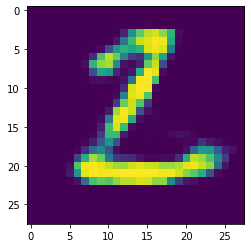

In [113]:
#@title ## Visualise the results
z_test_adv = torch.Tensor(z_test_adv_np).to(device)
x_test_hat = mnist_autoencoder.get_x_hat(z_test_adv)

plt.imshow(x_test_hat[1].detach().cpu().reshape(28, 28))
torch.argmax(mnist_classifier(x_test_hat[-2])).item()

In [115]:
from utils import save
save(path="./objects/adv_images_1000_mnist.pkl", params=x_test_hat)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)